In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import time

In [2]:
def delta(v_t_fire):
    if v_t_fire == 1.:
        return 1
    else:
        return 0

def depressing_synapses_model(x_t, y_t, z_t, t_rec, t_in, U, dt, v_t_fire):    
    dx = z_t / t_rec - U * x_t * delta(v_t_fire) * (1/dt)
    dy = - y_t / t_in + U * x_t * delta(v_t_fire) * (1/dt)
    dz = - z_t / t_rec + y_t / t_in
    
    x_t_ = x_t + dx * dt
    y_t_ = y_t + dy * dt
    z_t_ = z_t + dz * dt
    return x_t_, y_t_, z_t_

def IF_neuron(v_t, t_mem, I_syn, I_b, dt, v_t_fire, current_time, i_th_neuron, refrac_flag, intT):
    if refrac_flag[i_th_neuron, current_time] == 1:
        v_t_ = 13.5
    else:
        dv = (- v_t + I_syn + I_b) / t_mem
        v_t_ = v_t + dv * dt
        if v_t_ >= 15.:
            for i in range(30):
                if current_time + i >= intT:
                    pass
                else:
                    refrac_flag[i_th_neuron, current_time + i] = 1
            v_t_ = 13.5
            v_t_fire[i_th_neuron, current_time + 1] = 1.
            #print("neuron fired !")
    
    return v_t_

def raster(event_times_list, **kwargs):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

In [3]:
N = 40

J_ij = np.empty((0, N))
for i in range(N):
    tmp = np.zeros((1,N))
    for j in range(N):
        if randint(10) % 10 == 1:
            tmp[0, j] = 10 * np.random.normal(1, 0.5, 1)
    J_ij = np.append(J_ij, tmp, axis = 0)

In [8]:
x = 0.5
y = 0.5
z = 1 - x - y

#second
t_in= 0.003
t_mem = 0.030

U = np.zeros(N)
for i in range(N):
    U[i] = np.clip(np.random.normal(loc = 0.5, scale = 0.25, size = 1), 0.1, 0.9)

I_b = np.zeros(N)
for i in range(N):
    I_b[i] = np.random.uniform(low = 14.7 - 0.4, high = 14.7 + 0.4, size = 1)

t_rec = np.zeros(N)
for i in range(N):
    t_rec[i] = np.clip(np.random.normal(loc = 0.800, scale = 0.4 * 0.4, size = 1), 0.005, None)

dt = 0.0001

Total = 10
T = Total * (1/dt)
intT = int(T)

times = np.zeros(intT)

v_t = np.zeros((N, intT))
v_t_fire = np.zeros((N, intT))
refrac_flag = np.zeros((N, intT))
x_t = np.zeros((intT, N, N))
y_t = np.zeros((intT, N, N))
z_t = np.zeros((intT, N, N,))

# for debugging
I_syn = np.zeros(intT)

v_t[:,0] = 14.
x_t[0, :, :] = x
y_t[0, :, :] = y
z_t[0, :, :] = z

start = time.time()

for t in range(intT - 1):
    # this is i * dt mili second
    times[t+1] = t * dt

    if t % 1000 == 0:
        print("this is time {} sec/{} --- {} from previous stamp".format(t * dt, Total, time.time() - start))
        start = time.time()
    for i in range(N):
        # calculate the variable of i_th neuron
        I_syn_i = 0.
        #if (t +1) % 10 == 0:
        #    I_b[i] = np.random.normal(loc = 14.7 - 0.4, scale = 14.7 + 0.4, size = 1)
        for j in range(N):
            # j_th synapse of i_th neuron
            # calculate I_syn = sum_of J_ij * e_t_ij
            if j == i:
                pass
            else:
                #if i == 0:
                #    print("{} I_syn_{}".format(A_ij[j, i] * e_t[t, j, i], i))
                #    print("{} e_{}".format(e_t[t, :, :],t))
                #    print("{} r_t[t, i, j], {} e_t[t, i, j], {} ina_t[t, i, j], {} u_t[t, i, j]".format(r_t[t, i, j], e_t[t, i, j], ina_t[t, i, j], u_t[t, i, j]))
                x_t[t+1, i, j], y_t[t+1, i, j], z_t[t+1, i, j] = depressing_synapses_model(x_t[t, i, j], y_t[t, i, j], z_t[t, i, j],t_rec[i], t_in, U[i], dt, v_t_fire[i, t])
            I_syn_i += J_ij[j, i] * y_t[t, j, i]
        #if i == 0:
        #    print("{} I_syn_i total".format(I_syn_i))
        v_t[i, t+1] = IF_neuron(v_t[i, t], t_mem, I_syn_i, I_b[i], dt, v_t_fire, t, i, refrac_flag, intT)  
    if t == intT - 2:
        print("this is time {}\ndone !".format((t + 2)* dt))

this is time 0.0 sec/10 --- 0.0003807544708251953 from previous stamp
this is time 0.1 sec/10 --- 11.128458976745605 from previous stamp
this is time 0.2 sec/10 --- 9.868247747421265 from previous stamp
this is time 0.3 sec/10 --- 10.125535249710083 from previous stamp
this is time 0.4 sec/10 --- 10.074137926101685 from previous stamp
this is time 0.5 sec/10 --- 10.38507604598999 from previous stamp
this is time 0.6 sec/10 --- 10.479851961135864 from previous stamp
this is time 0.7000000000000001 sec/10 --- 10.083830833435059 from previous stamp
this is time 0.8 sec/10 --- 11.641108989715576 from previous stamp
this is time 0.9 sec/10 --- 10.11562180519104 from previous stamp
this is time 1.0 sec/10 --- 10.43390703201294 from previous stamp
this is time 1.1 sec/10 --- 10.00717806816101 from previous stamp
this is time 1.2 sec/10 --- 10.031013011932373 from previous stamp
this is time 1.3 sec/10 --- 10.028604984283447 from previous stamp
this is time 1.4000000000000001 sec/10 --- 10.603

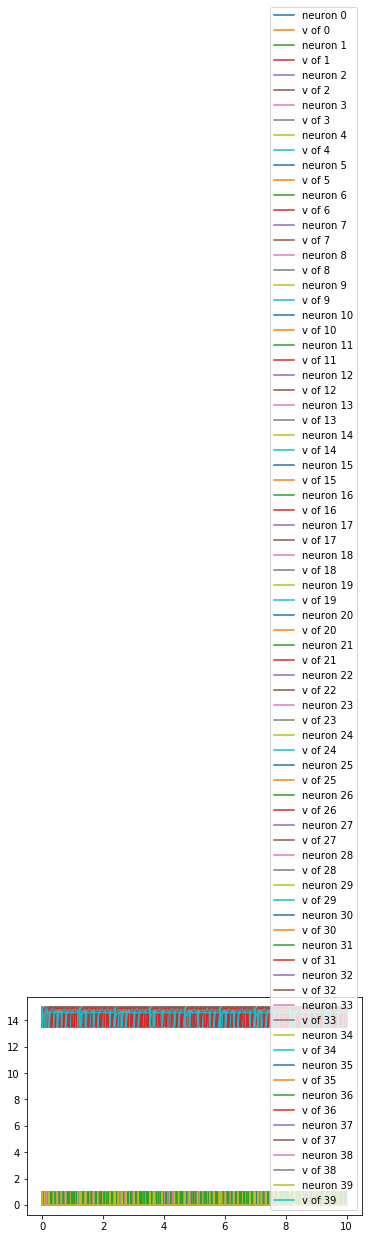

In [9]:
for i in range(N):
    plt.plot(times, v_t_fire[i, :], label='neuron {}'.format(i))
    plt.plot(times, v_t[i, :], label='v of {}'.format(i))

plt.legend(loc="lower right")

In [10]:
spikes = []

for j in range(N):
    spike = []
    for i in range(intT):
        if v_t_fire[j,i] == 1:
            spike.append(i)
            #print("{}th neuron fired spike appended".format(j))
    spikes.append(spike)
            
fig = plt.figure(figsize = (40, 10), dpi = 600)
ax = raster(spikes)
plt.title('small network raster plot')
plt.xlabel('time [sec]')
plt.ylabel('neuron')
fig.show()
plt.savefig("small network raster plot.png")

/Users/soliton/.pyenv/versions/anaconda3-4.2.0/envs/dynamicsenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


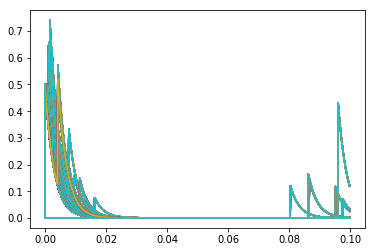

In [11]:
for j in range(N):
    for i in range(N):
        plt.plot(times[:1000], y_t[:1000, j, i], label='y')

In [12]:
for i in range(intT):
    if refrac_flag[0, i] == 1:
        print("{} fired / {} refrac period".format(v_t_fire[0, i], i))
    if v_t_fire[0, i] == 1:
        print("0th neuron fired at time {}".format(i))

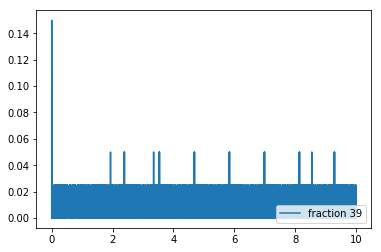

In [13]:
fractions = np.zeros(intT)

for t in range(intT):
    times[t] = t *dt
    fraction = 0
    for i in range(N):
        if v_t_fire[i, t] == 1:
            fraction +=1
    fraction = fraction / N
    #print(fraction)
    fractions[t] = fraction

plt.plot(times, fractions, label='fraction {}'.format(i))

plt.legend(loc="lower right")

In [29]:
I_b

array([14.43671875, 14.92582391, 15.02700051, 14.80572053, 14.70109422,
       14.3893962 , 14.60935281, 14.93683345, 14.43165573, 14.79594973,
       14.57062148, 14.46877587, 14.81609787, 15.03896724, 14.69610399,
       14.32126835, 14.84130123, 14.95774344, 14.75087525, 14.74037668,
       15.02020772, 14.43828318, 14.57008934, 14.70581344, 14.3623441 ,
       14.58076894, 14.77067809, 14.95289666, 14.32318641, 14.93902826,
       15.0726291 , 14.80396155, 14.47715664, 14.45296123, 14.90283277,
       14.35049177, 14.72954361, 14.52412826, 14.58487084, 14.66843575])

In [30]:
J_ij

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         6.99149923,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  7.31607886],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [14.23622988,  0.        , 15.7509449 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [45]:
t_rec

array([0.70354859, 0.94776132, 0.48069593, 0.7888447 , 0.76078196,
       0.9888614 , 0.89997696, 0.61523396, 0.79658153, 0.81668418,
       0.89638997, 0.84247271, 0.8888932 , 0.96659922, 0.66334897,
       0.85520329, 0.77425922, 0.7673969 , 0.88074242, 0.89453638,
       0.89875893, 0.81897603, 0.62828992, 1.08251075, 0.89099404,
       1.06693997, 0.82428675, 0.84779273, 0.79610775, 0.75077073,
       0.70184369, 0.92559554, 0.84337522, 0.67839918, 0.69778272,
       0.91749687, 0.93021359, 0.68116037, 0.98285426, 0.77349677])